# MNIST Digit Classification Neural Network 
# A Pure NumPy Implementation

## First implementation

In [1]:
import numpy as np

In [6]:
# A feedforward neural netowrk implementation for digit classification
# It uses ReLU activation for hidden layers and Softmax activation for the output
class NeuralNetwork:
    def __init__(self, input_neurons=784, hidden_layers=[512, 512], output_size=10):
        self.input_neurons = input_neurons
        self.hidden_layers = hidden_layers
        self.output_size = output_size

        # Lists to store the weights and biases for each layer
        self.weights = []
        self.biases = []

        # Input to first hidden layer
        self.weights.append(0.01 * np.random.randn(input_neurons, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Hidden layer to hidden layer
        # For each pair of hidden layers, initialize weight and bias
        for i in range(len(hidden_layers) - 1):
            # Weight matrix between hidden layer i and i + 1
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i+1]))
            # Bias vector for layer i + 1
            self.biases.append(np.zeros((1, hidden_layers[i+1])))
        
        # Last hidden layer to output
        self.weights.append(0.01 * np.random.randn(hidden_layers[len(hidden_layers)-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    # Loop through all layers (hidden + output)
    def forward(self, x_input):
        layers = [x_input] # Initialize input to the first layer

        for i in range(len(self.weights)):
            # Linear transformation: Z = A_prev @ W + b
            # - A_prev: activations from previous layer (or input)
            # - W: current layer's weights
            # - b: current layer's biases
            z = np.dot(layers[-1], self.weights[i]) + self.biases[i]
            layers.append(z)  # Store pre-activation values (needed for backprop)

            # Activation Functions (ReLU + SoftMax)
            if i == len(self.weights) - 1:
                # Output layer: apply Softmax
                # Exponentiate shifted values
                # Normalize to get probabilities (softmax)
                finalOutput = np.exp(layers[-1] - np.max(layers[-1], axis=1, keepdims=True))
                finalOutput = finalOutput / np.sum(finalOutput, axis=1, keepdims=True)
                layers.append(finalOutput)  # Append final output probabilities
            else:
                # Hidden layers: apply ReLU 
                # ReLU activation: max(0, z)
                layers.append(np.maximum(0, layers[-1]))
        
        # Return the final layer output (Softmax probabilities)
        return layers[-1]

In [7]:
# LossCategoricalCrossEntropy implementation
def LossCategoricalCrossEntropy(yPred, yTrue):
    # If predicted class has a prediction of 0% likelihood this prevents log(0), which would be infinity
    yPred = np.clip(yPred, 1e-10, 1 - 1e-10)

    # We calculate the sum of the log losses
    loss = -np.sum(yTrue * np.log(yPred), axis=1)

    # We calculate the average loss - this depends on the number of samples
    # So the return loss is the average loss not the summed up loss (which took me a while to understand)
    average_loss = np.mean(loss)

    return average_loss

In [8]:
myNeuralNet = NeuralNetwork()

In [10]:
# We finally get the predicted softmax probabilities for each of the 10 classes
result = myNeuralNet.forward(np.random.rand(1, 784))
result

array([[0.10048216, 0.09953871, 0.1003588 , 0.09982415, 0.09943986,
        0.10057567, 0.09938723, 0.10011669, 0.10024787, 0.10002886]])

## Backpropogation

In [21]:
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[512, 512], output_size=10):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights = []
        self.biases = []
        self.gradientsWeights = []
        self.gradientsBiases = []

        # Track number of training iterations (used for learning rate decay)
        self.iterations = 0

        # Input to first hidden layer
        self.weights.append(0.01 * np.random.randn(input_size, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Hidden layer to hidden layer
        # For each pair of hidden layers, initialize weight and bias
        for i in range(len(hidden_layers) - 1):
            # Weight matrix between hidden layer i and i + 1
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i+1]))
            # Bias vector for layer i + 1
            self.biases.append(np.zeros((1, hidden_layers[i+1])))
        
        # Last hidden layer to output
        self.weights.append(0.01 * np.random.randn(hidden_layers[len(hidden_layers)-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    def forward(self, inputs):
        # Store outputs at each layer for use in backpropagation
        self.outputs = [inputs]  # First element is input layer output (raw input)
        self.outputsTesting = ["inputs"]  # Optional list to track layer types

        # Loop through all layers
        for i in range(len(self.weights)):
            # Perform linear transformation: Z = A_prev @ W + b
            linear_output = np.dot(self.outputs[-1], self.weights[i]) + self.biases[i]
            self.outputs.append(linear_output)  # Store linear output
            self.outputsTesting.append("dense")

            # Apply activation function
            if i == len(self.weights) - 1:
                # Output layer uses softmax activation
                shifted_logits = linear_output - np.max(linear_output, axis=1, keepdims=True)  # for numerical stability
                exp_values = np.exp(shifted_logits)
                probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
                self.outputs.append(probabilities)  # Final predicted probabilities
                self.outputsTesting.append("softmax")
            else:
                # Hidden layers use ReLU activation
                activated_output = np.maximum(0, linear_output)
                self.outputs.append(activated_output)
                self.outputsTesting.append("relu")

        return self.outputs[-1]  # Return output of last layer (Softmax probabilities)
        
    # Backpropagation step to compute gradients for all layers
    # I still don't fully understand the workings behind this
    # For now, I have understood the code and extracted it from the nnfs textbook (https://nnfs.io/)
    def backwards(self, y_true):
        # Number of training examples in batch
        samples = len(self.outputs[-1])

        # If labels are one-hot encoded, convert them to discrete values
        if len(y_true.shape) == 2:
            print("Changing to discrete values")
            y_true = np.argmax(y_true, axis=1)

        # Compute derivative of softmax + categorical crossentropy loss
        # Let's make a copy so that we can modify safely
        dSoftMaxCrossEntropy = self.outputs[-1].copy()
        # Calculate gradient
        dSoftMaxCrossEntropy[range(samples), y_true] -= 1
        # Normalize gradient
        dSoftMaxCrossEntropy /= samples
        # print(dSoftMaxCrossEntropy)

        # Calculate gradients -> Calcualte derivative of weights, biases, and inputs (to continue to backpropagate)
        dInputs = np.dot(dSoftMaxCrossEntropy.copy(), self.weights[-1].T)
        dWeights = np.dot(self.outputs[-3].T, dSoftMaxCrossEntropy.copy())
        dBiases = np.sum(dSoftMaxCrossEntropy.copy(), axis=0, keepdims=True)
        
        # Store the gradients
        self.gradientsWeights = [dWeights] + self.gradientsWeights
        self.gradientsBiases = [dBiases] + self.gradientsBiases

        # Backpropagate through hidden layers
        i = -3  # index for linear input of previous layer
        j = -1  # index for current weight layer

        for _ in range(len(self.hidden_layers)):
            i -= 1
            j -= 1

            # ReLU backward: zero out gradients where the activation was <= 0
            dReLU = dInputs.copy()
            dReLU[self.outputs[i] <= 0] = 0

            # Continue backprop
            i -= 1
            dInputs = np.dot(dReLU, self.weights[j].T)
            dWeights = np.dot(self.outputs[i].T, dReLU)
            dBiases = np.sum(dReLU, axis=0, keepdims=True)

            # Prepend to keep order aligned with layer sequence
            self.gradientsWeights = [dWeights] + self.gradientsWeights
            self.gradientsBiases = [dBiases] + self.gradientsBiases

    def updateParams(self, lr=0.05, decay=1e-7):
        # Decay the learning rate
        lr = lr * (1. / (1. + decay * self.iterations))

        # Update weights using gradient descent
        for i in range(len(self.weights) - 1):
            assert self.weights[i].shape == self.gradientsWeights[i].shape
            self.weights[i] -= lr * self.gradientsWeights[i]

        # Update biases using gradient descent
        for i in range(len(self.biases) - 1):
            assert self.biases[i].shape == self.gradientsBiases[i].shape
            self.biases[i] -= lr * self.gradientsBiases[i]

        # Increment iteration count
        self.iterations += 1

    # LossCategoricalCrossEntropy implementation
def LossCategoricalCrossEntropy(yPred, yTrue):  
    # If predicted class has a prediction of 0% likelihood this prevents log(0), which would be infinity
    yPred = np.clip(yPred, 1e-10, 1 - 1e-10)

    # We calculate the sum of the log losses
    loss = -np.sum(yTrue * np.log(yPred), axis=1)

    # We calculate the average loss - this depends on the number of samples
    # So the return loss is the average loss not the summed up loss (which took me a while to understand)
    average_loss = np.mean(loss)

    return average_loss

# Utility: convert class indices to one-hot encoded labels
def sparse_to_one_hot(sparse_labels, num_classes):
    one_hot_encoded = np.zeros((len(sparse_labels), num_classes))
    one_hot_encoded[np.arange(len(sparse_labels)), sparse_labels] = 1
    return one_hot_encoded

In [12]:
myNeuralNet = NeuralNetwork(hidden_layers=[128, 128])

In [17]:
import gzip

# Load MNIST dataset from Yann LeCun's official MNIST page (http://yann.lecun.com/exdb/mnist/)
def extract_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32, count=4).byteswap()
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def extract_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num = np.frombuffer(f.read(8), dtype=np.uint32, count=2).byteswap()
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = extract_images("./MNISTdata/train-images-idx3-ubyte.gz")
train_labels = extract_labels("./MNISTdata/train-labels-idx1-ubyte.gz")
test_images = extract_images("./MNISTdata/t10k-images-idx3-ubyte.gz")
test_labels = extract_labels("./MNISTdata/t10k-labels-idx1-ubyte.gz")

## MNIST Training

In [23]:
data = train_images
dataLabels = train_labels

# Let's normalize the pixel values for the NN to learn faster
data = (data.astype(np.float32)-127.5)/127.5
data = data.reshape(60000, 784)

accuracies = []
losses = []

BATCH_SIZE = 32

# Main training loop
for epoch in range(1, 3):
    print(f'epoch: {epoch}')
    # Calculate how many steps (mini-batches) there are in each epoch
    train_steps = len(data) // BATCH_SIZE 

    for step in range(train_steps):
        # Slice the current batch of 32 images and corresponding labels using step index
        batch_X = data[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        batch_Y = dataLabels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]

        X = batch_X
        Y = batch_Y

        # Perform forward pass 
        output = myNeuralNet.forward(X)

        # Evaluate the model every 100 steps
        if step % 100 == 0:
            # Take the class with the highest predicted prob for each image in the batch
            predictions = np.argmax(output, axis=1)
            if len(Y.shape) == 2:
                Y = np.argmax(Y, axis=1)
            accuracy = np.mean(predictions == Y)
            
            loss = LossCategoricalCrossEntropy(output, sparse_to_one_hot(Y, 10))
            accuracies.append(accuracy)
            losses.append(loss)

            print(f'epoch: {epoch}, ' +
                    f'acc: {accuracy:.3f}, ' +
                    f'loss: {loss:.3f}')

        # Backward pass
        myNeuralNet.backwards(Y)

        # Update weights and biases
        myNeuralNet.updateParams(lr=0.5, decay=1e-6)
            

epoch: 1
epoch: 1, acc: 0.125, loss: 2.302
epoch: 1, acc: 0.438, loss: 1.645
epoch: 1, acc: 0.750, loss: 0.721
epoch: 1, acc: 0.719, loss: 0.749
epoch: 1, acc: 0.938, loss: 0.420
epoch: 1, acc: 0.844, loss: 0.574
epoch: 1, acc: 0.906, loss: 0.298
epoch: 1, acc: 0.938, loss: 0.200
epoch: 1, acc: 0.844, loss: 0.305
epoch: 1, acc: 0.906, loss: 0.215
epoch: 1, acc: 0.906, loss: 0.385
epoch: 1, acc: 0.906, loss: 0.401
epoch: 1, acc: 0.938, loss: 0.212
epoch: 1, acc: 0.875, loss: 0.403
epoch: 1, acc: 0.875, loss: 0.268
epoch: 1, acc: 0.938, loss: 0.235
epoch: 1, acc: 0.875, loss: 0.279
epoch: 1, acc: 0.906, loss: 0.210
epoch: 1, acc: 0.938, loss: 0.221
epoch: 2
epoch: 2, acc: 0.938, loss: 0.172
epoch: 2, acc: 0.844, loss: 0.375
epoch: 2, acc: 0.938, loss: 0.199
epoch: 2, acc: 1.000, loss: 0.059
epoch: 2, acc: 0.969, loss: 0.178
epoch: 2, acc: 0.844, loss: 0.274
epoch: 2, acc: 0.938, loss: 0.178
epoch: 2, acc: 0.969, loss: 0.085
epoch: 2, acc: 0.938, loss: 0.139
epoch: 2, acc: 0.969, loss: 0.

In [26]:
dataTest = test_images
dataTestLabels = test_labels

# Normalize again
dataTest = (dataTest.astype(np.float32)-127.5)/127.5

print(dataTest.shape) # (10000, 28, 28)
dataTest = dataTest.reshape(10000, 784)

X = dataTest
Y = dataTestLabels

output = myNeuralNet.forward(dataTest)

# Convert the softmax outputs into discrete class predictions (0-9)
predictions = np.argmax(output, axis=1)
if len(Y.shape) == 2:
    Y = np.argmax(Y, axis=1)

accuracy = np.mean(predictions == Y)
print(accuracy)

(10000, 28, 28)
0.9461


### Plotting training metrics

Text(0, 0.5, 'Value')

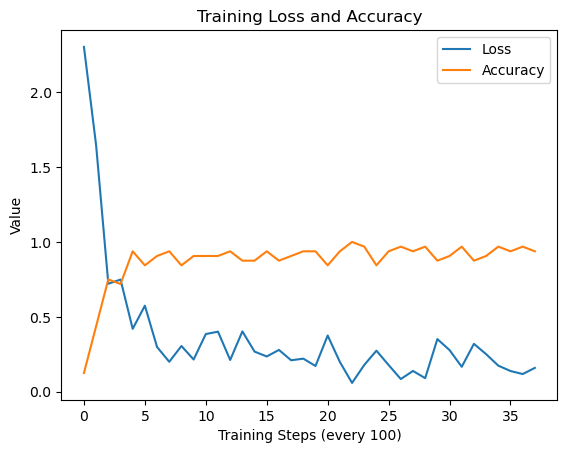

In [28]:
import matplotlib.pyplot as plt

plt.plot(losses, label = 'Loss')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Training Loss and Accuracy')
plt.xlabel('Training Steps (every 100)')
plt.ylabel('Value')

